In [1]:
import os
os.environ['GDAL_SKIP'] = 'DODS'

# from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl
import ipyleaflet as ilfl
import ipywidgets as iwg
# from ipywidgets import GridspecLayout, AppLayout, VBox, HBox, HTML, Label

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from sklearn.neighbors import BallTree


In [2]:
# Adapted from Alice's AGU talk

center = [65.73, -50.71]
zoom = 4
mainmap = ilfl.Map(basemap=ilfl.basemaps.Gaode.Satellite, center=center, zoom=zoom)

# # global dc, start, end, file, lon_l, lat_l, lon_r, lat_r

# # Pick date
# start = widgets.DatePicker(disabled=False)
# end = widgets.DatePicker(disabled=False)

# # Select from map
# dc = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}}, 
#                  polyline={}, polygon={}, circlemarker={})
# m.add_control(dc)
# dc = ilfl.DrawControl()
# mainmap.add_control(dc)

mker = ilfl.Marker(location=center, draggable=True)
mainmap.add_layer(mker)

# # Shapefile
# file = widgets.FileUpload(accept='.shp', multiple=False)

# # Bounding box
# lon_l = widgets.FloatText(description="lon")
# lat_l = widgets.FloatText(description="lat")
# lon_r = widgets.FloatText(description="lon")
# lat_r = widgets.FloatText(description="lat")

iwg.AppLayout(header=iwg.HTML("<h2>Drag the marker to your region of interest</h1>"), center=mainmap)

# return(AppLayout(header = VBox([HTML("<h1>Select area (time and space)</h1>"),
#                      HBox([Label("Start Date:"), start, 
#                            Label("End Date:"), end])]),
#                  center = m,
#                  right_sidebar = VBox([HTML("<h3>or upload shapefile<h3>"), file, HTML("<h3> <h3>"), HTML("<h3>or bounding box<h3>"), 
#                          Label("Bottom-left corner"), lon_l, lat_l, Label("Upper-right corner"), lon_r, lat_r])))

AppLayout(children=(HTML(value='<h2>Drag the marker to your region of interest</h1>', layout=Layout(grid_area=…

In [4]:
query_pt = [mker.location[-1], mker.location[0]]
query_pt

[-50.185546875, 69.06856318696033]

In [5]:
def check_crossing(lon_list):
    """
    Checks if the antimeridian is crossed.
    """
    import itertools
    return any(abs(pair[0] - pair[1]) > 180.0 for pair in itertools.combinations(lon_list, 2))

In [6]:
ls8 = pd.read_excel('./LS8_cornerPts.xlsx')

geometry_collection = []
    
for index, row in ls8.iterrows():
    lon_list = [row.lon_UL, row.lon_UR, row.lon_LR, row.lon_LL]
    if check_crossing(lon_list):
        set1 = [x % 360.0 for x in lon_list]
        set2 = [x % -360.0 for x in lon_list]
        poly1 = Polygon([(set1[0], row.lat_UL), (set1[1], row.lat_UR), (set1[2], row.lat_LR), (set1[3], row.lat_LL)])
        poly2 = Polygon([(set2[0], row.lat_UL), (set2[1], row.lat_UR), (set2[2], row.lat_LR), (set2[3], row.lat_LL)])
        feature_geometry = MultiPolygon([poly1, poly2])
    else:
        feature_geometry = Polygon([(row.lon_UL, row.lat_UL), (row.lon_UR, row.lat_UR), (row.lon_LR, row.lat_LR), (row.lon_LL, row.lat_LL)])
        
    geometry_collection.append(feature_geometry)
    
ls8_gdf = gpd.GeoDataFrame(ls8, geometry=geometry_collection)

ls8_gdf = ls8_gdf.drop(['lat_UL', 'lon_UL', 'lat_UR', 'lon_UR', 'lat_LL', 'lon_LL', 'lat_LR', 'lon_LR'], axis=1)
ls8_gdf

,path,row,lat_CTR,lon_CTR,geometry
0,1,1,80.774791,3.210620,"POLYGON ((5.42400 81.92300, 9.94700 80.30700, ..."
1,1,2,80.021757,-4.274059,"POLYGON ((-3.20700 81.20300, 2.30700 79.69900,..."
2,1,3,79.129883,-10.647337,"POLYGON ((-10.43200 80.32200, -4.40400 78.9360..."
3,1,4,78.130377,-16.029408,"POLYGON ((-16.40900 79.32000, -10.20700 78.048..."
4,1,5,77.048078,-20.572231,"POLYGON ((-21.35100 78.22700, -15.19300 77.061..."
...,...,...,...,...,...
57778,233,244,81.352691,28.155956,"POLYGON ((35.64600 81.84800, 30.97900 80.24500..."
57779,233,245,81.718750,18.566867,"POLYGON ((25.77700 82.38700, 22.59000 80.69100..."
57780,233,246,81.844418,8.404287,"POLYGON ((14.79400 82.68000, 13.57600 80.92900..."
57781,233,247,81.718750,-1.758293,"POLYGON ((3.34700 82.69600, 4.31400 80.94200, ..."


In [7]:
def lquery(point_geometry, polygon_data):
    # points_geometry: 2-element list showing [lon, lat]
    # points: a N-by-2 numpy array. 1st column: lon; 2nd coulmn: lat
    # Adapted from Shane's GeoStack
    points = np.vstack((polygon_data.lon_CTR.values, polygon_data.lat_CTR.values)).T
    points *= np.pi/180.
    LSBall = BallTree(points, metric='haversine')
    
    q = np.array(point_geometry)
    q *= np.pi/180.
    
    # idx = LSBall.query(q.reshape(1,-1),k=1,return_distance=False,breadth_first=True)
    idx = LSBall.query_radius(q.reshape(1,-1), r=0.05, return_distance=False)
    # path = int(ls8.path.iloc[idx.flatten()].values)
    # row = int(ls8.row.iloc[idx.flatten()].values)
    print(idx)
    # return path, row
    
lquery(query_pt, ls8_gdf)

[array([21308,  1501, 21060,  1253, 20073, 20815, 21062,  2737, 21309,
         2490,  2243, 20320,  1996,  1748, 20814,  2984,  2242,  1995,
        20567, 21061, 19825,  3231, 19330,  2488,  2241, 20566,  1746,
         1500, 20319,  1252,  2736, 20071, 20072, 19824,  2489,  1499,
         1747,  1994, 19577, 20318, 20565, 20813])                    ]


In [8]:
def lquery_alt(point_geometry, polygon_data):
    # points_geometry: a shapely.geometry.Point object or a 2-element list showing [lon, lat]
    # polygon_data: the LS8 GeoDataFrame object
    # return: print P/R

    if type(point_geometry) is Point:
        pt = point_geometry
    else:
        pt = Point(point_geometry)

    for idx, row in polygon_data.iterrows():
        if pt.within(row.geometry):
            print(idx, row.path, row.row)
            
# llquery_alt(Point([np.random.sample()*180, np.random.sample()*88]), ls8_gdf)query_alt(query_pt, ls8_gdf)

In [8]:
# %%timeit
# lquery_alt(Point([np.random.sample()*180, np.random.sample()*88]), ls8_gdf)

In [9]:
def lquery_combined(point_geometry, polygon_data):
    # points_geometry: 2-element list showing [lon, lat]
    # polygon_data: the LS8 GeoDataFrame object
    points = np.vstack((polygon_data.lon_CTR.values, polygon_data.lat_CTR.values)).T
    points *= np.pi/180.
    LSBall = BallTree(points, metric='haversine')
    
    q = np.array(point_geometry)
    q *= np.pi/180.
    if type(point_geometry) is Point:
        pt = point_geometry
    else:
        pt = Point(point_geometry)
    
    # idx = LSBall.query(q.reshape(1,-1),k=1,return_distance=False,breadth_first=True)
    pre_selection = LSBall.query_radius(q.reshape(1,-1), r=0.05, return_distance=False)
    # path = int(ls8.path.iloc[idx.flatten()].values)
    # row = int(ls8.row.iloc[idx.flatten()].values)
    pre_selection_idx = pre_selection[0]
    pre_selection_idx.sort()
    
    polygon_pre_selection = polygon_data.loc[pre_selection_idx]
    
    selection_idx = []
    for idx, row in polygon_pre_selection.iterrows():
        if pt.within(row.geometry):
            selection_idx.append(idx)
            # print(idx, row.path, row.row)
    
    return selection_idx
    # return gdf_idx
    # print(idx.flatten())
    # print(polygon_data.loc[gdf_idx])
    # return path, row

In [10]:
# %%timeit
# lquery_combined(Point([np.random.sample()*180, np.random.sample()*88]), ls8_gdf)

In [10]:
idx = lquery_combined(query_pt, ls8_gdf)

ls8_gdf.loc[idx]

,path,row,lat_CTR,lon_CTR,geometry
1746,8,11,69.606373,-47.857343,"POLYGON ((-49.23200 70.69500, -44.50500 69.955..."
1747,8,12,68.279631,-49.545762,"POLYGON ((-50.91000 69.35600, -46.41400 68.660..."
1994,9,11,69.606373,-49.402408,"POLYGON ((-50.77700 70.69500, -46.05000 69.955..."
2242,10,11,69.606373,-50.947472,"POLYGON ((-52.32200 70.69500, -47.59500 69.955..."
20319,82,233,69.606373,-49.668847,"POLYGON ((-46.43100 69.19800, -50.90400 68.507..."
20567,83,233,69.606373,-51.213911,"POLYGON ((-47.97600 69.19800, -52.44900 68.507..."
20814,84,232,68.279631,-51.070557,"POLYGON ((-48.04600 67.84400, -52.30600 67.192..."


In [11]:
# query_pt.reverse()

selectionmap = ilfl.Map(basemap=ilfl.basemaps.Gaode.Satellite, center=query_pt, zoom=zoom)
selectionmker = ilfl.Marker(location=query_pt, draggable=False)
selectionmap.add_layer(selectionmker)

iwg.AppLayout(left_sidebar=iwg.VBox([iwg.HTML("<h3>Select Path/Row<h3>")]), center=selectionmap)

pr_options = [('{:03d}/{:03d}'.format(ls8_gdf.loc[i, 'path'], ls8_gdf.loc[i, 'row']) ,i) for i in idx]
print(pr_options)

pr_menu = iwg.Dropdown(options=pr_options, description='Path/Row:')

# pr_menu.

def on_change(change):
    tmp = ilfl.Marker(location=[69, -50], draggable=True)
    selectionmap.add_layer(tmp)
    # print("changed to %s" % change['new'])

pr_menu.observe(on_change, names='value')

iwg.AppLayout(left_sidebar=iwg.VBox([iwg.HTML("<h2>Drag the marker to your region of interest</h1>"), pr_menu]), center=mainmap)

# return(AppLayout(header = VBox([HTML("<h1>Select area (time and space)</h1>"),
#                      HBox([Label("Start Date:"), start, 
#                            Label("End Date:"), end])]),
#                  center = m,
#                  right_sidebar = VBox([HTML("<h3>or upload shapefile<h3>"), file, HTML("<h3> <h3>"), HTML("<h3>or bounding box<h3>"), 
#                          Label("Bottom-left corner"), lon_l, lat_l, Label("Upper-right corner"), lon_r, lat_r])))

[('008/011', 1746), ('008/012', 1747), ('009/011', 1994), ('010/011', 2242), ('082/233', 20319), ('083/233', 20567), ('084/232', 20814)]


AppLayout(children=(VBox(children=(HTML(value='<h2>Drag the marker to your region of interest</h1>'), Dropdown…

In [25]:
# !aws s3 ls s3://landsat-pds/c1/L8/217/015/ --no-sign-request

In [13]:
import boto3
import botocore
# from botocore import UNSIGNED
# from botocore.config import Config
# according to https://github.com/boto/boto3/issues/1200
s3 = boto3.client('s3', region_name='us-west-2', config=botocore.config.Config(signature_version=botocore.UNSIGNED))

# import awswrangler as wr
# objects = wr.s3.list_objects('s3://landsat-pds/c1/L8/217/015/', boto_session=s3)

In [45]:
# List objects present in a bucket
# response = s3.list_objects(Bucket="landsat-pds", MaxKeys=10, Prefix='LC08_L1TP_217015', Delimiter='txt')
response = s3.list_objects_v2(Bucket="landsat-pds", MaxKeys=1000, Prefix='c1/L8/009/011/LC08_L1TP_', Delimiter='/')
#                           MaxKeys=10, 
#                            Preffix="only_files_starting_with_this_string")

# # Uploading and downloading files
# s3.upload_file(Filename=📄, Bucket=🗑, Key=🔑)
# s3.download_file(Filename=📄, Bucket=🗑, Key=🔑)

# # Get object's metadata (last modification time, size in bytes etc.)
# response = s3.head_object(Bucket=🗑, Key=🔑)

# # Delete object
# s3.delete_object(Bucket=🗑, Key=🔑)

# result = client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')
for scene in response.get('CommonPrefixes'):
    print(scene.get('Prefix'))

c1/L8/009/011/LC08_L1TP_009011_20130401_20170505_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20130411_20170505_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20130427_20170505_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20130902_20170502_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20130918_20170502_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20131004_20170429_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20131020_20170429_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140209_20170425_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140225_20170425_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140313_20170425_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140329_20170424_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140414_20170423_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140516_20170422_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140601_20170422_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140703_20170421_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140719_20170421_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140804_20170420_01_T1/
c1/L8/009/011/LC08_L1TP_009011_20140905_20170419

In [47]:
response = s3.list_objects_v2(Bucket="landsat-pds", MaxKeys=1000, Prefix='c1/L8/009/011/LC08_L1TP_009011_20200703_20200708_01_T1/LC08_L1TP_009011_20200703_20200708_01_T1_B4.TIF')
for record in response['Contents']:
    if record['Key'].endswith('.TIF'):
        file1 = 'https://landsat-pds.s3.amazonaws.com/' + record['Key']
        
response = s3.list_objects_v2(Bucket="landsat-pds", MaxKeys=1000, Prefix='c1/L8/009/011/LC08_L1TP_009011_20200820_20200905_01_T1/LC08_L1TP_009011_20200820_20200905_01_T1_B4.TIF')
for record in response['Contents']:
    if record['Key'].endswith('.TIF'):
        file2 = 'https://landsat-pds.s3.amazonaws.com/' + record['Key']
        
print(file1, file2)

https://landsat-pds.s3.amazonaws.com/c1/L8/009/011/LC08_L1TP_009011_20200703_20200708_01_T1/LC08_L1TP_009011_20200703_20200708_01_T1_B4.TIF https://landsat-pds.s3.amazonaws.com/c1/L8/009/011/LC08_L1TP_009011_20200820_20200905_01_T1/LC08_L1TP_009011_20200820_20200905_01_T1_B4.TIF


In [16]:
import sys
sys.path.append('/home/whyj/Projects/Github/CARST/Utilities/Python')

In [17]:
from UtilRaster import SingleRaster, RasterVelos
from UtilConfig import ConfParams
from UtilPX import ampcor_task, writeout_ampcor_task
from UtilXYZ import ZArray, DuoZArray, AmpcoroffFile, points_in_polygon

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2021-03-02 20:51:37,570 - matplotlib - DEBUG - (private) matplotlib data path: /home/whyj/anaconda3/envs/carst/lib/python3.9/site-packages/matplotlib/mpl-data
2021-03-02 20:51:37,571 - matplotlib - DEBUG - matplotlib data path: /home/whyj/anaconda3/envs/carst/lib/python3.9/site-packages/matplotlib/mpl-data
2021-03-02 20:51:37,573 - matplotlib - DEBUG - CONFIGDIR=/home/whyj/.config/matplotlib
2021-03-02 20:51:37,574 - matplotlib - DEBUG - matplotlib version 3.3.4
2021-03-02 20:51:37,574 - matplotlib - DEBUG - interactive is False
2021-03-02 20:51:37,575 - matplotlib - DEBUG

In [48]:
a = SingleRaster(file1, date='2020-07-03')
b = SingleRaster(file2, date='2020-08-20')
a.AmpcorPrep()
b.AmpcorPrep()

Calling gdalbuildvrt...
gdalbuildvrt LC08_L1TP_009011_20200703_20200708_01_T1_B4.TIF.vrt https://landsat-pds.s3.amazonaws.com/c1/L8/009/011/LC08_L1TP_009011_20200703_20200708_01_T1/LC08_L1TP_009011_20200703_20200708_01_T1_B4.TIF
Calling gdalbuildvrt...
gdalbuildvrt LC08_L1TP_009011_20200820_20200905_01_T1_B4.TIF.vrt https://landsat-pds.s3.amazonaws.com/c1/L8/009/011/LC08_L1TP_009011_20200820_20200905_01_T1/LC08_L1TP_009011_20200820_20200905_01_T1_B4.TIF


In [49]:
inipath = 'param.ini'
ini = ConfParams(inipath)
ini.ReadParam()
ini.imagepair['image1'] = file1
ini.imagepair['image2'] = file2
ini.imagepair['image1_date'] = '2020-07-03'
ini.imagepair['image2_date'] = '2020-08-20'
ini.VerifyParam()

In [50]:
task = ampcor_task([a, b], ini)
writeout_ampcor_task(task, ini)

Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 20
Skip Sample Across: 20
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 20
Skip Sample Across: 20
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 20
Skip Sample Across: 20
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 20
Skip Sample Across: 20
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 20
Skip Sample Across: 20
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 20
Skip Sample Across: 20
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 20
Skip Sample Across: 20
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 20
Skip Sample Across: 20


In [51]:
ampoff = AmpcoroffFile(ini.rawoutput['label_ampcor'] + '.p')
ampoff.Load()
ampoff.SetIni(ini)
ampoff.FillwithNAN()   # fill holes with nan
ampoff.Ampcoroff2Velo()
ampoff.Velo2XYV(generate_xyztext=ini.rawoutput['if_generate_xyztext'])
ampoff.XYV2Raster()

In [36]:
import rasterio
from rasterio.plot import show

2021-03-02 22:22:31,908 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x7f9959d9f6a0>
2021-03-02 22:22:31,908 - rasterio.env - DEBUG - Starting outermost env
2021-03-02 22:22:31,909 - rasterio.env - DEBUG - No GDAL environment exists
2021-03-02 22:22:31,909 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x7f9959d9fa60> created
2021-03-02 22:22:31,910 - rasterio._env - DEBUG - GDAL_DATA found in environment: '/home/whyj/anaconda3/envs/carst/share/gdal'.
2021-03-02 22:22:31,910 - rasterio._env - DEBUG - PROJ_LIB found in environment: '/home/whyj/anaconda3/envs/carst/share/proj'.
2021-03-02 22:22:31,911 - rasterio._env - DEBUG - Started GDALEnv <rasterio._env.GDALEnv object at 0x7f9959d9fa60>.
2021-03-02 22:22:31,912 - rasterio.env - DEBUG - Entered env context: <rasterio.env.Env object at 0x7f9959d9f6a0>
2021-03-02 22:22:31,912 - rasterio._base - DEBUG - Sharing flag: 0
2021-03-02 22:22:36,974 - rasterio._base - DEBUG - Nodata 

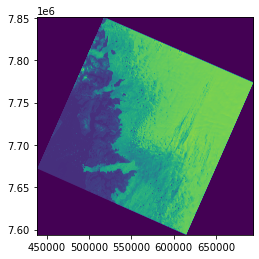

<AxesSubplot:>

In [52]:
dataset = rasterio.open(file1)
show(dataset)

2021-03-02 22:22:54,373 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x7f9959d9f4c0>
2021-03-02 22:22:54,375 - rasterio.env - DEBUG - Starting outermost env
2021-03-02 22:22:54,376 - rasterio.env - DEBUG - No GDAL environment exists
2021-03-02 22:22:54,376 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x7f9921f15dc0> created
2021-03-02 22:22:54,377 - rasterio._env - DEBUG - GDAL_DATA found in environment: '/home/whyj/anaconda3/envs/carst/share/gdal'.
2021-03-02 22:22:54,377 - rasterio._env - DEBUG - PROJ_LIB found in environment: '/home/whyj/anaconda3/envs/carst/share/proj'.
2021-03-02 22:22:54,378 - rasterio._env - DEBUG - Started GDALEnv <rasterio._env.GDALEnv object at 0x7f9921f15dc0>.
2021-03-02 22:22:54,378 - rasterio.env - DEBUG - Entered env context: <rasterio.env.Env object at 0x7f9959d9f4c0>
2021-03-02 22:22:54,378 - rasterio._base - DEBUG - Sharing flag: 0
2021-03-02 22:22:54,379 - rasterio._base - DEBUG - Nodata 

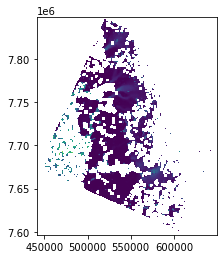

<AxesSubplot:>

In [54]:
dataset = rasterio.open('20200703-20200820_velo-raw_mag.tif')
show(dataset)